# Hybrid - Part 1: Text Preprocessing & Representations for Semi-supervised learning

**Environment Setup**

In [1]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
import re
import time
pd.set_option('max_colwidth', 1000)
!pip install spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
!pip install gensim
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import sklearn   
import scipy.io as scio
import os
!pip install bert-serving-server 
!pip install bert-serving-client
from sklearn.model_selection import cross_val_score, GridSearchCV
import functions


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached wordcloud-1.8.0-cp36-cp36m-manylinux1_x86_64.whl (365 kB)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
        


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

In [2]:
#Read in bank transactions
df = pd.read_csv(r'df_postfeat_time_series_FINAL.csv',low_memory=False,encoding='latin1')

In [3]:
#External resources
stopwords = pd.read_csv(r'stopwords.csv',low_memory=False,encoding='latin1')
abb = pd.read_csv(r'normalisation.csv',low_memory=False,encoding='latin1')

In [5]:
import os
os.getcwd()

'/project'

## 1. Text Preprocessing

In [5]:
df_ = df.copy()

### 1.1 Stopword and special character Removals

In [4]:
#Remove stopwords and special characters
functions.removals(df,stopwords,'description')
df.description = df.description.replace('\s+', ' ', regex=True)
df = df[df['description'] != '']

### 1.2 Text Normalisation

In [5]:
#Normalise abbrications
functions.abbrivations(df,'description')

### 1.3 Tokenisation and Lemmatisation

In [6]:
#tokenise and lemmatise description
df['description'] = functions.tokenise_lemmatise(df,'description')

In [7]:
#Count the top 10 frequent words in text description
cnt = Counter()
for text in df["description"].values:
    for word in text:
        cnt[word] += 1

cnt.most_common(10)

[('payment', 27072),
 ('ltd', 12317),
 ('fast', 10309),
 ('debit', 5944),
 ('bank', 5413),
 ('transaction', 4886),
 ('bill', 4467),
 ('direct', 4467),
 ('purchase', 4129),
 ('vat', 4116)]

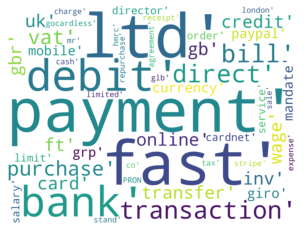

In [88]:
#Create words cloud of top 50 frequenct words in description
a = cnt.most_common(50)
a = pd.DataFrame.from_dict(a).rename(columns={0:'word', 1:'frequencies'})
text = a['word'].values

# Create and generate a word cloud image:
wordcloud = WordCloud(width = 4000,height = 3000,background_color = 'white').generate(str(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

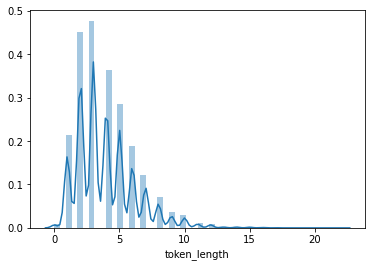

In [8]:
# count the number of tokens of each description
df['token_length'] = [len(token) for token in df.description]
#plot the graph to visualise
g = sns.distplot(df.token_length)

In [9]:
#Remove transactions with zero tokens
df = df[df['token_length']!=0].reset_index(drop=True)

## 2. Semi-supervised Learning Set

In [10]:
#Create dataset with transactions labelled by local or/and global rules only
df_semi = df[(df['global']!=0)&(df['standard_transaction_type_id']==-1)|(df['standard_transaction_type_id']!=-1)]
functions.explore(df_semi)

The shape of the dataset is:(7642, 24)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7642 entries, 11 to 114289
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          7642 non-null   object 
 1   amount                        7642 non-null   float64
 2   balance                       7642 non-null   float64
 3   date                          7642 non-null   object 
 4   description                   7642 non-null   object 
 5   platform_bank                 7642 non-null   object 
 6   crd_id                        7642 non-null   object 
 7   debit_binary                  7642 non-null   int64  
 8   standard_transaction_type_id  7642 non-null   int64  
 9   local_rule_creation_date      4610 non-null   object 
 10  local_rule_index              7642 non-null   int64  
 11  global                        7642 non-null   int64  
 12  date_only         

,name,amount,balance,date,description,platform_bank,crd_id,debit_binary,standard_transaction_type_id,local_rule_creation_date,...,week_of_month_2,week_of_month_3,week_of_month_4,foreign_binary,financing_binary,account_binary,hmrc_vat,hmrc_corp,hmrc_paye,token_length
11,15GIFTS LTD,-0.26,194669.39,2019-07-05,"[non, sterling, transaction, fee]",HSBC,08813058-835d-4398-9698-8ea38a59bbf7,1,11,2019-12-10,...,0,0,0,0,0,0,0,0,0,4
21,15GIFTS LTD,-7.56,150511.69,2019-07-10,"[non, sterling, transaction, fee]",HSBC,08813058-835d-4398-9698-8ea38a59bbf7,1,11,2019-12-10,...,1,0,0,0,0,0,0,0,0,4
26,15GIFTS LTD,-4412.42,146080.83,2019-07-11,"[commercial, card]",HSBC,08813058-835d-4398-9698-8ea38a59bbf7,1,11,2019-10-31,...,1,0,0,0,0,0,0,0,0,2
29,15GIFTS LTD,-8.08,145415.00,2019-07-12,"[non, sterling, transaction, fee]",HSBC,08813058-835d-4398-9698-8ea38a59bbf7,1,11,2019-12-10,...,1,0,0,0,0,0,0,0,0,4
35,15GIFTS LTD,-18.07,145376.93,2019-07-15,"[ee, limit]",HSBC,08813058-835d-4398-9698-8ea38a59bbf7,1,11,2019-10-31,...,1,0,0,0,0,0,0,0,0,2


In [13]:
df_semi_ = df_semi.copy()

In [11]:
#Trun unlabelled transactions to -1
semi_y_labeled = df_semi[df_semi['standard_transaction_type_id'] != -1].loc[:,'standard_transaction_type_id']
semi_y_unlabeled = df_semi[df_semi['standard_transaction_type_id'] == -1].loc[:,'standard_transaction_type_id']

#Randomly set 30% of labeled transactions as unlabeled, use for evaluation
rng = np.random.RandomState(0)
semi_y_labeled[rng.rand(len(semi_y_labeled)) < 0.3] = -1
semi_y_label = pd.concat([semi_y_labeled,semi_y_unlabeled], axis=1)
semi_y_label = semi_y_label.fillna(-1)
semi_y_label = semi_y_label.iloc[:,0]
semi_y_label = semi_y_label.astype('int')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [12]:
#Get the index of labelled and unlabelled ones 
labeled_indices = semi_y_label[semi_y_label!=-1].index.to_list()
unlabeled_indices = semi_y_label[semi_y_label==-1].index.to_list()
#Acquire the true labels of the testing set
a = df_semi[df_semi['standard_transaction_type_id'] != -1].loc[:,'standard_transaction_type_id']
test_true_labels = a[a.index.isin(unlabeled_indices)]
test_indices = test_true_labels.index.to_list()

In [13]:
#Getting the training and testing sets
df_semi_labeled = df_semi[df_semi.index.isin(labeled_indices)]
df_semi_unlabeled = df_semi[df_semi.index.isin(unlabeled_indices)]
df_semi_test =  df_semi[df_semi.index.isin(test_indices)]
df_semi_train = df_semi[~df_semi.index.isin(test_indices)]
train_indices = df_semi_train.index

### 2.1 Word Representation

In [14]:
X_label_train = [' '.join(x) for x in df_semi_labeled['description']]
y_label_train = df_semi_labeled['standard_transaction_type_id']

#### 2.1.1 Frequency-based Methods

In [21]:
#Checking n-grams in frequency-based models
svc = SVC(random_state=200)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

def count_vect(df,x):
    ngram = list()
    for n in range(1,6):
        if x >0 :
            bow =  CountVectorizer(ngram_range=(1,n))
            tfidf=  TfidfVectorizer(ngram_range=(1,n))
            i = (1,n)
        else:
            bow =  CountVectorizer(ngram_range=(n,n))
            tfidf=  TfidfVectorizer(ngram_range=(n,n))
            i = (n,n)
            
        tfidf_matrix = tfidf.fit_transform(df)
        bow_matrix = bow.fit_transform(df)
        tfidf_cv = cross_val_score(svc, tfidf_matrix, y_label_train, cv=kfold, scoring='f1_macro').mean()
        bow_cv = cross_val_score(svc, bow_matrix, y_label_train, cv=kfold, scoring='f1_macro').mean()
        print('n-gram :{}, Bag of Words F1 Score: {},TF-iDF F1 Score: {} '.format(i,bow_cv,tfidf_cv))
        ngram.append({'n': n, 'score': tfidf_cv, 'type': 'TF-iDF'})
        ngram.append({'n': n, 'score': bow_cv, 'type': 'Bag of Words'})
    return pd.DataFrame(ngram)

#Check the F1 score of single n-grams
n_gram_1 = count_vect(X_label_train,0)

n-gram :(1, 1), Bag of Words F1 Score: 0.8646963664895339,TF-iDF F1 Score: 0.8720578388649477 
n-gram :(2, 2), Bag of Words F1 Score: 0.8422906050758913,TF-iDF F1 Score: 0.8457552323784665 
n-gram :(3, 3), Bag of Words F1 Score: 0.6379532923512115,TF-iDF F1 Score: 0.6430310080734021 
n-gram :(4, 4), Bag of Words F1 Score: 0.46023929660874946,TF-iDF F1 Score: 0.46316181741969087 
n-gram :(5, 5), Bag of Words F1 Score: 0.39508237408667796,TF-iDF F1 Score: 0.40186932914337986 


In [20]:
#Check the F1 score of mixed n-grams
n_gram_2 = count_vect(X_label_train,1)

n-gram :(1, 1), Bag of Words F1 Score: 0.8646963664895339,TF-iDF F1 Score: 0.8720578388649477 
n-gram :(1, 2), Bag of Words F1 Score: 0.8653180296476798,TF-iDF F1 Score: 0.8693025828346956 
n-gram :(1, 3), Bag of Words F1 Score: 0.8633753106490092,TF-iDF F1 Score: 0.8694296889001787 
n-gram :(1, 4), Bag of Words F1 Score: 0.8517075239379972,TF-iDF F1 Score: 0.8587592052171888 
n-gram :(1, 5), Bag of Words F1 Score: 0.8493626914873247,TF-iDF F1 Score: 0.856485782125136 


In [18]:
#Plot n-gram results
def plot_count(df):
    plt.figure(figsize=(10,4))
    a= df[df['type']=='Bag of Words']
    b= df[df['type']=='TF-iDF']

    #Plot line graphs
    plt.plot(a['n'], a['score'], label= "Bag of Words",color='steelblue',linewidth=3)
    plt.plot(b['n'], b['score'], label="TF-IDF",color='skyblue',linewidth=3)

    #Format plot
    plt.xlabel('n-grams')
    plt.ylabel('F1 Score')
    plt.title("BoW and TF-iDF Performance by n-gram values")
    plt.legend()
    plt.show()

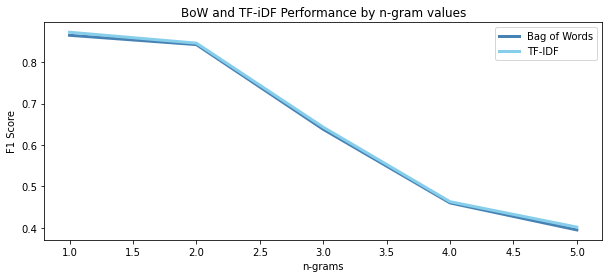

In [22]:
#Plot of single n-grams
plot_count(n_gram_1)

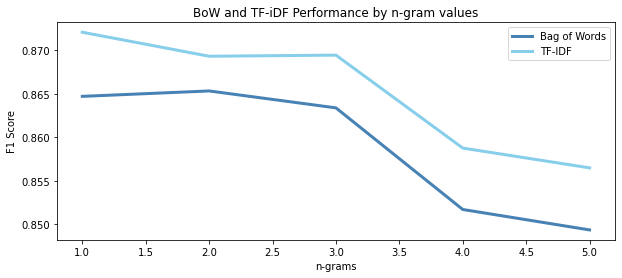

In [23]:
#Plot of mixed n-grams
plot_count(n_gram_2)

In [31]:
#Selecting maximum features for the better performed model
def max_feat(index,model,model_name):
    vec =  model(ngram_range=index)
    vec_matrix = vec.fit_transform(X_label_train)
    a = vec_matrix.shape
    
    vec_result = list()
    for n in range(100, a[1], 100):
        vec = model(ngram_range=index,max_features=n)
        vec_matrix = vec.fit_transform(X_label_train)
        score_countVec = cross_val_score(svc, vec_matrix, y_label_train, cv=kfold, scoring='f1_macro').mean()

        vec_result.append({'max_feature': n,  'score': score_countVec})
    print('finished')
    
    vec_result_df = pd.DataFrame(vec_result)
    plt.figure(figsize=(10,4))
    #Plot line graphs
    plt.plot(vec_result_df['max_feature'], vec_result_df['score'],color='steelblue',linewidth=3)
    #Format plot
    plt.xlabel('Number of features')
    plt.ylabel('F1 Score')
    plt.title("Maximum Number of Features in {}".format(model_name))
    plt.show()
    
    max_score = vec_result_df['score'].max()
    a = vec_result_df[vec_result_df['score'] == max_score]
    a = a.iloc[0]['max_feature']
    print('maximum feature is {}'.format(a))

finished


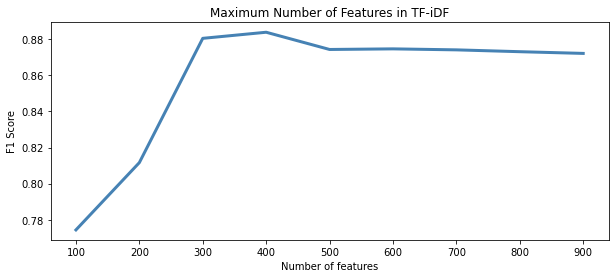

maximum feature is 400.0


In [27]:
#checking the max feature number
max_feat((1,1),TfidfVectorizer,'TF-IDF')

In [32]:
#vectorised text for count based methods
tf = TfidfVectorizer(max_features=400)
tfidf_matrix = tf.fit_transform(X_label_train)

#### 2.2.2 Prediction-based Methods

**Word2vec: Self-trained**

In [26]:
#Convert description to list for modelling
X_train_list = df_semi_labeled['description'].tolist()

In [27]:
#Train model
word2vec_self_model = Word2Vec(X_train_list, size=300, window=5, min_count=2, iter=100)

#Save and load model for future use
word2vec_self_model.save(r'word2vec_self.w2v')
word2vec_self_model.wv.save_word2vec_format(r'word2vec_self.bin',binary=False)

word2vec_self = word2vec_self_model.wv.load_word2vec_format(r'word2vec_self.bin',binary=False)

In [28]:
#checking all posibilities and generating representations
def w2v_vectorise(texts, word2vec_model):
        i = 0
        index2word_set = set(word2vec_model.index2word)
        description_vector = np.zeros((word2vec_model.vector_size))
        for text in texts:
                if text in index2word_set:
                        description_vector = np.add(description_vector, word2vec_model[text])
                        i += 1
        text_vector = np.divide(description_vector, i)
        return text_vector

startTime = time.time()
vector_list = []
i = 0
for texts in X_train_list:
        i += 1
        if i % 400 == 0: 
                print('%.2fs used for generating word embeddings for top %d transaction description' %(time.time()-startTime,i))
        vector_list.append(w2v_vectorise(texts, word2vec_self) )
        word2vec_self_matrix= np.array(vector_list)
        
print('Total time used:%.2fs' % (time.time() - startTime) )

0.05s used for generating word embeddings for top 400 transaction description
0.18s used for generating word embeddings for top 800 transaction description


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


0.40s used for generating word embeddings for top 1200 transaction description
0.68s used for generating word embeddings for top 1600 transaction description
1.12s used for generating word embeddings for top 2000 transaction description
1.69s used for generating word embeddings for top 2400 transaction description
2.43s used for generating word embeddings for top 2800 transaction description
3.26s used for generating word embeddings for top 3200 transaction description
Total time used:3.40s


In [29]:
#Form matrix for comparison
word2vec_self_matrix[np.isnan(word2vec_self_matrix)] = 0
word2vec_self_matrix = pd.DataFrame(word2vec_self_matrix)

**Word2Vec: Google news pre-trained**

In [30]:
#Load pre-trained model
word2vec_pre_model = gensim.models.KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin.gz', binary=True)  
word2vec_pre_model.vector_size

300

In [31]:
#Check OOV words
def oov(texts, model, check_function):
    exist_total = 0
    total = 0
    total_word_set = set()
    oov_set = set()
    #check all possibilities
    for line in texts:
        for text in line :
            total +=1
            total_word_set.add(text)
            if check_function(model, text):
                exist_total +=1

    for text in total_word_set:
        if check_function(model, text):
            pass
        else:
            oov_set.add(text)
    
    distinct_oov = round(len(oov_set)/len(total_word_set), 4)
    total_oov = round(1 - exist_total/total, 4)
    print('Percentage of distinct out of vocabulary words: {:.2f}%'.format(distinct_oov*100))
    print('Total percentage of out of vocabulary words in the word set: {:.2f}%'.format(total_oov*100))
    print(oov_set)
    return distinct_oov, total_oov, oov_set

def w2v_check(model, text):
    return (text in model.vocab) or (text.upper() in model.vocab)or (text.capitalize() in model.vocab)

X_train = df_semi_labeled['description']
distinct_oov, total_oov, oov_set = oov(X_train, word2vec_pre_model, w2v_check)

Percentage of distinct out of vocabulary words: 25.03%
Total percentage of out of vocabulary words in the word set: 8.89%
{'ibsfp', 'cotax', 'pgq', 'adyou', 'nipok', 'mobitrans', 'barclayloan', 'elberry', 'gocardless', 'scoloan', 'scukl', 'soben', 'rjim', 'kqnmqo', 'esmeloan', 'shreena', 'exanhakxt', 'rbq', 'fnbk', 'nmike', 'rilqbi', 'gdmuteyn', 'hdcpxxb', 'umq', 'znocp', 'mobilelab', 'kqx', 'aedq', 'refun', 'fgchs', 'easyinvoicefinance', 'arwbppxc', 'oxij', 'zqvxb', 'baatfp', 'kxxc', 'prtnr', 'oxkt', 'uczaipwct', 'ppwqtds', 'vtlumlq', 'kflfj', 'wwnq', 'stryczkos', 'heqh', 'iydebxcur', 'zwzrprlbzlt', 'vrqfp', 'financrbs', 'aqpv', 'bsobenco', 'appzyla', 'zgt', 'ohksnqx', 'propertiesinv', 'vbzb', 'cjmdc', '-PRON-', 'oolx', 'sabj', 'wgawoh', 'aoqcobnk', 'hbpv', 'qij', 'cktgk', 'hubx', 'lhzqvpkyc', 'ixla', 'anwg', 'oskw', 'sqdpt', 'opbt', 'rtyfp', 'oynt', 'trceo', 'gadbrook', 'firmcard', 'dkau', 'qgw', 'qewawfp', 'hardbase', 'datrixpurple', 'systemsaving', 'oibrhhc', 'northwdvia', 'ppwyn',

In [32]:
#Form word2vec embeddings
def w2v_embeddings(model, texts):
        matrix =[]
        for text in texts:
            oov_matrix = []
            if len(text) > 0 :
                for word in text:
                    if  word in model.vocab:
                        oov_matrix.append(model[word])
                    elif word.upper() in model.vocab:
                        oov_matrix.append(model[word.upper()])
                    elif word.capitalize() in model.vocab:
                        oov_matrix.append(model[word.capitalize()])

            if len(oov_matrix) == 0:
                oov_matrix.append(np.zeros(model.vector_size))
            matrix.append(np.mean(oov_matrix, axis=0))
        return matrix

w2v_pre_model = w2v_embeddings(word2vec_pre_model,np.array(X_train))
w2v_pre_model_df = pd.DataFrame(w2v_pre_model)

**GloVe: 300D**

In [33]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [36]:
#glove_input_file = r'C:\Users\sophie\Desktop\Dissertation Project\glove.840B.300d.txt'

#Load pre-trained model
word2vec_output_file = r'glove.840B.300d.word2vec.txt'
#(count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)
#print(count, '\n', dimensions)
glove = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [38]:
#Checking oov words
def glov_check(model, text):
    return text in model

distinct_oov, total_oov, oob_words = oov(X_train, glove, glov_check)

Percentage of distinct out of vocabulary words: 27.67%
Total percentage of out of vocabulary words in the word set: 9.28%
{'ibsfp', 'cotax', 'pgq', 'adyou', 'nipok', 'mvrc', 'mobitrans', 'barclayloan', 'elberry', 'gocardless', 'scoloan', 'scukl', 'soben', 'rjim', 'kqnmqo', 'esmeloan', 'shreena', 'exanhakxt', 'rbq', 'fnbk', 'nmike', 'rilqbi', 'gdmuteyn', 'hdcpxxb', 'umq', 'znocp', 'shoesmith', 'mobilelab', 'kqx', 'aedq', 'fgchs', 'easyinvoicefinance', 'arwbppxc', 'oxij', 'yfp', 'zqvxb', 'baatfp', 'kxxc', 'prtnr', 'oxkt', 'uczaipwct', 'ppwqtds', 'vtlumlq', 'topiwala', 'kflfj', 'stryczkos', 'wwnq', 'iydebxcur', 'heqh', 'vrqfp', 'zwzrprlbzlt', 'financrbs', 'aqpv', 'bsobenco', 'appzyla', 'zgt', 'ohksnqx', 'propertiesinv', 'vbzb', 'cjmdc', '-PRON-', 'oolx', 'sabj', 'hodnett', 'wgawoh', 'aoqcobnk', 'pattenden', 'hbpv', 'qij', 'cktgk', 'hubx', 'pqq', 'lhzqvpkyc', 'ixla', 'alphera', 'anwg', 'oskw', 'sqdpt', 'opbt', 'rtyfp', 'oynt', 'trceo', 'gadbrook', 'firmcard', 'dkau', 'qgw', 'jtw', 'qewawfp

In [39]:
#Form glove embeddings
def glov_embeddings(model, texts):
        matrix =[]
        for text in texts:
            oov_matrix = []
            if len(text) > 0 :
                for word in text:
                    if  word in model.vocab:
                        oov_matrix.append(model[word])

            if len(oov_matrix) == 0:
                oov_matrix.append(np.zeros(model.vector_size))
            matrix.append(np.mean(oov_matrix, axis=0))
        return matrix

glove_pre_model_ = glov_embeddings(glove,np.array(X_train))
glove_pre_df = pd.DataFrame(glove_pre_model_)

**4.4.2 BERT**

In [40]:
#Load model
from bert_serving.client import BertClient
bc = BertClient()
#Form BERT embeddings
bert_embed = bc.encode(X_label_train)

#### 4.4.3 Feature Selection

In [36]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#Calculating f1-scores for comparison
score_w2v_self = cross_val_score(svc, word2vec_self_matrix, y_label_train, cv=kfold, scoring='f1_macro')
score_w2v_pre_train = cross_val_score(svc, w2v_pre_model_df, y_label_train, cv=kfold, scoring='f1_macro')
score_tfidf = cross_val_score(svc, tfidf_matrix, y_label_train,cv=kfold, scoring='f1_macro')
score_glov = cross_val_score(svc, glove_pre_df, y_label_train, cv=kfold, scoring='f1_macro')
score_bert = cross_val_score(svc, bert_embed, y_label_train, cv=kfold, scoring='f1_macro')
print(score_tfidf.mean())
print(score_w2v_self.mean())
print(score_w2v_pre_train.mean())
print(score_glov.mean())
print(score_bert.mean())

0.8838990974409544
0.6725194983396925
0.8088771970334572
0.7968291106509121
0.6647502096704541


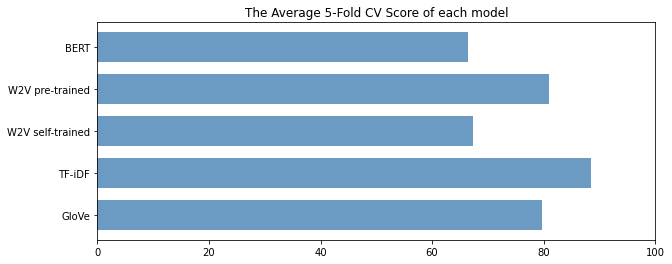

In [38]:
plt.figure(figsize=(10,4))

# Plot the score of each model
plt.barh(range(5), [score_glov.mean()*100,score_tfidf.mean()*100,score_w2v_self.mean()*100,score_w2v_pre_train.mean()*100,score_bert.mean()*100], height=0.7, color='steelblue', alpha=0.8)
plt.yticks(range(5), ['GloVe','TF-iDF','W2V self-trained', 'W2V pre-trained','BERT'])
plt.xlim(0,100)
plt.title("The Average 5-Fold CV Score of each model")
plt.savefig(r'semi_text_eva.png',bbox_inches='tight')